In [ ]:
# ───────────────────────────────────────────────
# Step 0: Install Required Libraries (if not already installed)
# ───────────────────────────────────────────────
!pip install datasets pandas -q

# ───────────────────────────────────────────────
# Step 1: Import Libraries & Mount Google Drive
# ───────────────────────────────────────────────
import os
import pandas as pd
from datasets import load_dataset
from google.colab import drive

# Constants for paths and target row counts
DRIVE_SAVE_DIR = "/content/drive/MyDrive/new2"       # Save directory on Google Drive
DATASET_CACHE_DIR = "/content/cache"                 # Cache directory for dataset downloads
FINAL_DATASET_TARGET_ROWS = 100000                   # Total expected rows from combined datasets

def setup_google_drive_directory(save_directory: str) -> None:
    """
    Mounts Google Drive and ensures that the target save directory exists.
    If the directory does not exist, it creates one and prints a confirmation message.
    """
    # Mount Google Drive if not already mounted
    drive.mount('/content/drive', force_remount=True)

    if not os.path.exists(save_directory):
        os.makedirs(save_directory)
        print(f"Created directory: {save_directory}")
    else:
        print(f"Directory already exists: {save_directory}")

def load_and_clean_dataset(dataset_id: str, split: str = "train", sample_size: int = None) -> pd.DataFrame:
    """
    Loads a dataset from Hugging Face and performs cleaning:

    - Downloads the dataset using a specified cache directory.
    - If 'sample_size' is set and the dataset contains more rows than the limit,
      selects only the first 'sample_size' rows.
    - Converts columns with dictionary or list values to strings to avoid
      unhashable type issues.

    Args:
        dataset_id (str): Identifier of the dataset to load.
        split (str): Which split of the dataset to load (default "train").
        sample_size (int): Optional limit on the number of rows to load.

    Returns:
        pd.DataFrame: The cleaned dataset.
    """
    print(f"Loading dataset: {dataset_id} (split: {split})")
    dataset = load_dataset(dataset_id, split=split, cache_dir=DATASET_CACHE_DIR)

    # Data validation: Ensure sample_size is a positive integer if provided
    if sample_size is not None:
        try:
            if sample_size <= 0:
                raise ValueError("Sample size must be greater than zero.")
        except Exception as error:
            print(f"Invalid sample_size argument: {error}")
            raise

        if len(dataset) > sample_size:
            dataset = dataset.select(range(sample_size))

    df = pd.DataFrame(dataset)

    # Convert any dict or list column values into strings to avoid unhashable errors
    for column in df.columns:
        if df[column].apply(lambda value: isinstance(value, (dict, list))).any():
            df[column] = df[column].apply(lambda value: str(value) if isinstance(value, (dict, list)) else value)

    return df

def sanitize_column_entries(dataframe: pd.DataFrame, column_name: str) -> pd.DataFrame:
    """
    Ensures that a specific column's entries are converted to strings.
    This conversion prevents issues with unhashable types during later processing.

    Args:
        dataframe (pd.DataFrame): DataFrame that may contain the target column.
        column_name (str): The name of the column to sanitize.

    Returns:
        pd.DataFrame: DataFrame with the column sanitized.
    """
    if column_name in dataframe.columns:
        dataframe[column_name] = dataframe[column_name].astype(str)
        print(f"Fixed column '{column_name}' by converting all values to string.")
    else:
        print(f"Warning: Column '{column_name}' not found in the dataset.")
    return dataframe

def combine_datasets(dataframes: list, target_total_rows: int) -> pd.DataFrame:
    """
    Concatenates multiple DataFrames and adjusts the final dataset to meet a target row count.

    - Combines the passed dataframes.
    - If the total row count exceeds the target, takes a random sample with a fixed seed.
    - If the total row count is less than the target, issues a warning.

    Args:
        dataframes (list): List of DataFrames to be concatenated.
        target_total_rows (int): The desired number of rows in the final DataFrame.

    Returns:
        pd.DataFrame: The combined DataFrame with (ideally) exactly target_total_rows.
    """
    combined_df = pd.concat(dataframes, ignore_index=True)
    actual_rows = combined_df.shape[0]
    print(f"Combined dataset row count before adjustment: {actual_rows}")

    if actual_rows > target_total_rows:
        # Alternative strategy could involve more balanced pooling by weighting each dataset,
        # but here we uniformly sample to reach the target.
        combined_df = combined_df.sample(target_total_rows, random_state=42).reset_index(drop=True)
        print(f"Trimmed combined dataset to exactly {target_total_rows} rows using random sampling.")
    elif actual_rows < target_total_rows:
        print("WARNING: The combined dataset has less than the target row count!")

    return combined_df

def main():
    """
    Main function that orchestrates the pipeline:

    1. Set up the Google Drive directory.
    2. Load and clean individual datasets with specified sample sizes.
    3. Perform targeted cleaning on specific columns.
    4. Combine the datasets, ensuring the final DataFrame matches the target row count.
    5. Save the final combined dataset to Google Drive.
    """
    # Setup Google Drive save directory
    setup_google_drive_directory(DRIVE_SAVE_DIR)

    # Load individual datasets with sample sizes chosen to roughly sum to 100k rows:
    # Twitter: 20k, Instagram: 15k, LinkedIn: 15k, Exorde: 50k
    twitter_df = load_and_clean_dataset("tweets_hate_speech_detection", sample_size=20000)
    instagram_df = load_and_clean_dataset("RafaM97/marketing_social_media", sample_size=15000)
    linkedin_df = load_and_clean_dataset("Shekswess/social-media-instruction", sample_size=15000)
    exorde_df = load_and_clean_dataset("Exorde/exorde-social-media-december-2024-week1", sample_size=50000)

    # Apply specific column sanitizations based on domain knowledge
    linkedin_df = sanitize_column_entries(linkedin_df, "generated_text")
    exorde_df = sanitize_column_entries(exorde_df, "secondary_themes")

    # Print individual dataset shapes for tracking purposes
    print("\nIndividual dataset sizes:")
    print("   Twitter:", twitter_df.shape)
    print("   Instagram:", instagram_df.shape)
    print("   LinkedIn:", linkedin_df.shape)
    print("   Exorde:", exorde_df.shape)

    # Combine datasets into one final DataFrame
    final_combined_df = combine_datasets(
        [twitter_df, instagram_df, linkedin_df, exorde_df],
        target_total_rows=FINAL_DATASET_TARGET_ROWS
    )

    # Save the final combined dataset to the specified Google Drive directory as CSV
    combined_file_path = os.path.join(DRIVE_SAVE_DIR, "combined_social_media_dataset.csv")
    final_combined_df.to_csv(combined_file_path, index=False)
    print(f"\nFinal Combined Dataset saved to: {combined_file_path} with {final_combined_df.shape[0]} rows")

# Run the main pipeline if this script is executed directly.
if __name__ == "__main__":
    main()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.58k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/2.07M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.11M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/31962 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/17197 [00:00<?, ? examples/s]

Loading dataset: RafaM97/marketing_social_media (split: train)


README.md:   0%|          | 0.00/1.89k [00:00<?, ?B/s]

marketing_social_media_dataset_v2.json:   0%|          | 0.00/499k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/689 [00:00<?, ? examples/s]

Loading dataset: Shekswess/social-media-instruction (split: train)


README.md:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/328k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/500 [00:00<?, ? examples/s]

Loading dataset: Exorde/exorde-social-media-december-2024-week1 (split: train)


README.md:   0%|          | 0.00/7.47k [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/132 [00:00<?, ?it/s]

processed_data_0.parquet:   0%|          | 0.00/101M [00:00<?, ?B/s]

processed_data_1.parquet:   0%|          | 0.00/114M [00:00<?, ?B/s]

processed_data_10.parquet:   0%|          | 0.00/127M [00:00<?, ?B/s]

processed_data_100.parquet:   0%|          | 0.00/114M [00:00<?, ?B/s]

processed_data_101.parquet:   0%|          | 0.00/122M [00:00<?, ?B/s]

processed_data_102.parquet:   0%|          | 0.00/122M [00:00<?, ?B/s]

processed_data_103.parquet:   0%|          | 0.00/124M [00:00<?, ?B/s]

processed_data_104.parquet:   0%|          | 0.00/124M [00:00<?, ?B/s]

processed_data_105.parquet:   0%|          | 0.00/126M [00:00<?, ?B/s]

processed_data_106.parquet:   0%|          | 0.00/131M [00:00<?, ?B/s]

processed_data_107.parquet:   0%|          | 0.00/127M [00:00<?, ?B/s]

processed_data_108.parquet:   0%|          | 0.00/129M [00:00<?, ?B/s]

processed_data_109.parquet:   0%|          | 0.00/130M [00:00<?, ?B/s]

processed_data_11.parquet:   0%|          | 0.00/127M [00:00<?, ?B/s]

processed_data_110.parquet:   0%|          | 0.00/128M [00:00<?, ?B/s]

processed_data_111.parquet:   0%|          | 0.00/126M [00:00<?, ?B/s]

processed_data_112.parquet:   0%|          | 0.00/123M [00:00<?, ?B/s]

processed_data_113.parquet:   0%|          | 0.00/121M [00:00<?, ?B/s]

processed_data_114.parquet:   0%|          | 0.00/122M [00:00<?, ?B/s]

processed_data_115.parquet:   0%|          | 0.00/119M [00:00<?, ?B/s]

processed_data_116.parquet:   0%|          | 0.00/115M [00:00<?, ?B/s]

processed_data_117.parquet:   0%|          | 0.00/116M [00:00<?, ?B/s]

processed_data_118.parquet:   0%|          | 0.00/114M [00:00<?, ?B/s]

processed_data_119.parquet:   0%|          | 0.00/116M [00:00<?, ?B/s]

processed_data_12.parquet:   0%|          | 0.00/124M [00:00<?, ?B/s]

processed_data_120.parquet:   0%|          | 0.00/115M [00:00<?, ?B/s]

processed_data_121.parquet:   0%|          | 0.00/118M [00:00<?, ?B/s]

processed_data_122.parquet:   0%|          | 0.00/119M [00:00<?, ?B/s]

processed_data_123.parquet:   0%|          | 0.00/120M [00:00<?, ?B/s]

processed_data_124.parquet:   0%|          | 0.00/121M [00:00<?, ?B/s]

processed_data_125.parquet:   0%|          | 0.00/124M [00:00<?, ?B/s]

processed_data_126.parquet:   0%|          | 0.00/123M [00:00<?, ?B/s]

processed_data_127.parquet:   0%|          | 0.00/124M [00:00<?, ?B/s]

processed_data_128.parquet:   0%|          | 0.00/126M [00:00<?, ?B/s]

processed_data_129.parquet:   0%|          | 0.00/127M [00:00<?, ?B/s]

processed_data_13.parquet:   0%|          | 0.00/124M [00:00<?, ?B/s]

processed_data_130.parquet:   0%|          | 0.00/122M [00:00<?, ?B/s]

processed_data_131.parquet:   0%|          | 0.00/121M [00:00<?, ?B/s]

processed_data_14.parquet:   0%|          | 0.00/128M [00:00<?, ?B/s]

processed_data_15.parquet:   0%|          | 0.00/127M [00:00<?, ?B/s]

processed_data_16.parquet:   0%|          | 0.00/123M [00:00<?, ?B/s]

processed_data_17.parquet:   0%|          | 0.00/120M [00:00<?, ?B/s]

processed_data_18.parquet:   0%|          | 0.00/120M [00:00<?, ?B/s]

processed_data_19.parquet:   0%|          | 0.00/120M [00:00<?, ?B/s]

processed_data_2.parquet:   0%|          | 0.00/115M [00:00<?, ?B/s]

processed_data_20.parquet:   0%|          | 0.00/122M [00:00<?, ?B/s]

processed_data_21.parquet:   0%|          | 0.00/117M [00:00<?, ?B/s]

processed_data_22.parquet:   0%|          | 0.00/117M [00:00<?, ?B/s]

processed_data_23.parquet:   0%|          | 0.00/119M [00:00<?, ?B/s]

processed_data_24.parquet:   0%|          | 0.00/119M [00:00<?, ?B/s]

processed_data_25.parquet:   0%|          | 0.00/123M [00:00<?, ?B/s]

processed_data_26.parquet:   0%|          | 0.00/123M [00:00<?, ?B/s]

processed_data_27.parquet:   0%|          | 0.00/125M [00:00<?, ?B/s]

processed_data_28.parquet:   0%|          | 0.00/128M [00:00<?, ?B/s]

processed_data_29.parquet:   0%|          | 0.00/130M [00:00<?, ?B/s]

processed_data_3.parquet:   0%|          | 0.00/119M [00:00<?, ?B/s]

processed_data_30.parquet:   0%|          | 0.00/131M [00:00<?, ?B/s]

processed_data_31.parquet:   0%|          | 0.00/131M [00:00<?, ?B/s]

processed_data_32.parquet:   0%|          | 0.00/128M [00:00<?, ?B/s]

processed_data_33.parquet:   0%|          | 0.00/128M [00:00<?, ?B/s]

processed_data_34.parquet:   0%|          | 0.00/128M [00:00<?, ?B/s]

processed_data_35.parquet:   0%|          | 0.00/131M [00:00<?, ?B/s]

processed_data_36.parquet:   0%|          | 0.00/129M [00:00<?, ?B/s]

processed_data_37.parquet:   0%|          | 0.00/127M [00:00<?, ?B/s]

processed_data_38.parquet:   0%|          | 0.00/127M [00:00<?, ?B/s]

processed_data_39.parquet:   0%|          | 0.00/121M [00:00<?, ?B/s]

processed_data_4.parquet:   0%|          | 0.00/117M [00:00<?, ?B/s]

processed_data_40.parquet:   0%|          | 0.00/120M [00:00<?, ?B/s]

processed_data_41.parquet:   0%|          | 0.00/121M [00:00<?, ?B/s]

processed_data_42.parquet:   0%|          | 0.00/122M [00:00<?, ?B/s]

processed_data_43.parquet:   0%|          | 0.00/124M [00:00<?, ?B/s]

processed_data_44.parquet:   0%|          | 0.00/125M [00:00<?, ?B/s]

processed_data_45.parquet:   0%|          | 0.00/127M [00:00<?, ?B/s]

processed_data_46.parquet:   0%|          | 0.00/128M [00:00<?, ?B/s]

processed_data_47.parquet:   0%|          | 0.00/127M [00:00<?, ?B/s]

processed_data_48.parquet:   0%|          | 0.00/131M [00:00<?, ?B/s]

processed_data_49.parquet:   0%|          | 0.00/132M [00:00<?, ?B/s]

processed_data_5.parquet:   0%|          | 0.00/115M [00:00<?, ?B/s]

processed_data_50.parquet:   0%|          | 0.00/132M [00:00<?, ?B/s]

processed_data_51.parquet:   0%|          | 0.00/131M [00:00<?, ?B/s]

processed_data_52.parquet:   0%|          | 0.00/128M [00:00<?, ?B/s]

processed_data_53.parquet:   0%|          | 0.00/123M [00:00<?, ?B/s]

processed_data_54.parquet:   0%|          | 0.00/124M [00:00<?, ?B/s]

processed_data_55.parquet:   0%|          | 0.00/122M [00:00<?, ?B/s]

processed_data_56.parquet:   0%|          | 0.00/121M [00:00<?, ?B/s]

processed_data_57.parquet:   0%|          | 0.00/121M [00:00<?, ?B/s]

processed_data_58.parquet:   0%|          | 0.00/118M [00:00<?, ?B/s]

processed_data_59.parquet:   0%|          | 0.00/116M [00:00<?, ?B/s]

processed_data_6.parquet:   0%|          | 0.00/121M [00:00<?, ?B/s]

processed_data_60.parquet:   0%|          | 0.00/117M [00:00<?, ?B/s]

processed_data_61.parquet:   0%|          | 0.00/116M [00:00<?, ?B/s]

processed_data_62.parquet:   0%|          | 0.00/117M [00:00<?, ?B/s]

processed_data_63.parquet:   0%|          | 0.00/121M [00:00<?, ?B/s]

processed_data_64.parquet:   0%|          | 0.00/124M [00:00<?, ?B/s]

processed_data_65.parquet:   0%|          | 0.00/126M [00:00<?, ?B/s]

processed_data_66.parquet:   0%|          | 0.00/124M [00:00<?, ?B/s]

processed_data_67.parquet:   0%|          | 0.00/125M [00:00<?, ?B/s]

processed_data_68.parquet:   0%|          | 0.00/125M [00:00<?, ?B/s]

processed_data_69.parquet:   0%|          | 0.00/128M [00:00<?, ?B/s]

processed_data_7.parquet:   0%|          | 0.00/122M [00:00<?, ?B/s]

processed_data_70.parquet:   0%|          | 0.00/129M [00:00<?, ?B/s]

processed_data_71.parquet:   0%|          | 0.00/127M [00:00<?, ?B/s]

processed_data_72.parquet:   0%|          | 0.00/127M [00:00<?, ?B/s]

processed_data_73.parquet:   0%|          | 0.00/123M [00:00<?, ?B/s]

processed_data_74.parquet:   0%|          | 0.00/123M [00:00<?, ?B/s]

processed_data_75.parquet:   0%|          | 0.00/123M [00:00<?, ?B/s]

processed_data_76.parquet:   0%|          | 0.00/120M [00:00<?, ?B/s]

processed_data_77.parquet:   0%|          | 0.00/121M [00:00<?, ?B/s]

processed_data_78.parquet:   0%|          | 0.00/117M [00:00<?, ?B/s]

processed_data_79.parquet:   0%|          | 0.00/117M [00:00<?, ?B/s]

processed_data_8.parquet:   0%|          | 0.00/124M [00:00<?, ?B/s]

processed_data_80.parquet:   0%|          | 0.00/118M [00:00<?, ?B/s]

processed_data_81.parquet:   0%|          | 0.00/119M [00:00<?, ?B/s]

processed_data_82.parquet:   0%|          | 0.00/121M [00:00<?, ?B/s]

processed_data_83.parquet:   0%|          | 0.00/124M [00:00<?, ?B/s]

processed_data_84.parquet:   0%|          | 0.00/125M [00:00<?, ?B/s]

processed_data_85.parquet:   0%|          | 0.00/124M [00:00<?, ?B/s]

processed_data_86.parquet:   0%|          | 0.00/128M [00:00<?, ?B/s]

processed_data_87.parquet:   0%|          | 0.00/127M [00:00<?, ?B/s]

processed_data_88.parquet:   0%|          | 0.00/128M [00:00<?, ?B/s]

processed_data_89.parquet:   0%|          | 0.00/130M [00:00<?, ?B/s]

processed_data_9.parquet:   0%|          | 0.00/123M [00:00<?, ?B/s]

processed_data_90.parquet:   0%|          | 0.00/127M [00:00<?, ?B/s]

processed_data_91.parquet:   0%|          | 0.00/124M [00:00<?, ?B/s]

processed_data_92.parquet:   0%|          | 0.00/124M [00:00<?, ?B/s]

processed_data_93.parquet:   0%|          | 0.00/124M [00:00<?, ?B/s]

processed_data_94.parquet:   0%|          | 0.00/121M [00:00<?, ?B/s]

processed_data_95.parquet:   0%|          | 0.00/118M [00:00<?, ?B/s]

processed_data_96.parquet:   0%|          | 0.00/118M [00:00<?, ?B/s]

processed_data_97.parquet:   0%|          | 0.00/116M [00:00<?, ?B/s]

processed_data_98.parquet:   0%|          | 0.00/114M [00:00<?, ?B/s]

processed_data_99.parquet:   0%|          | 0.00/114M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/65542211 [00:00<?, ? examples/s]

Loading dataset shards:   0%|          | 0/44 [00:00<?, ?it/s]

Fixed column 'generated_text' by converting all values to string.
Fixed column 'secondary_themes' by converting all values to string.

Individual dataset sizes:
   Twitter: (20000, 2)
   Instagram: (689, 3)
   LinkedIn: (500, 4)
   Exorde: (50000, 10)
Combined dataset row count before adjustment: 71189

Final Combined Dataset saved to: /content/drive/MyDrive/new2/combined_social_media_dataset.csv with 71189 rows


## Dataset Aggregation and Cleaning Pipeline – Summary

### Objective
The script collects, cleans, and merges four publicly available social media datasets from Hugging Face. It outputs a single unified CSV file, suitable for further analysis or model training, and saves it to Google Drive.

---

### Key Steps

1. **Library Installation and Imports**  
   - Installs essential libraries such as `datasets` and `pandas`.
   - Imports Python modules for file handling, data processing, and dataset loading.

2. **Google Drive Integration**  
   - Mounts Google Drive to the Colab environment.  
   - Verifies the existence of the target directory at `/content/drive/MyDrive/new2`. If it does not exist, the directory is created.

3. **Dataset Loading and Sampling**  
   - Four datasets are loaded with the following intended sample sizes:
     - Twitter Hate Speech Detection: 20,000 rows  
     - Instagram Marketing: 15,000 rows  
     - LinkedIn Social Media Instruction: 15,000 rows  
     - Exorde Social Media Trends: 50,000 rows  
   - The datasets are limited in size for performance and memory efficiency.

4. **Data Cleaning and Column Handling**  
   - Ensures all dictionary or list-type column values are converted to string to prevent type errors.
   - Specifically sanitises the 'generated_text' and 'secondary_themes' columns, which are known to cause compatibility issues.

5. **Combining and Validating the Final Dataset**  
   - All datasets are concatenated into a single DataFrame.
   - If the resulting dataset exceeds the target row count, a sample is taken to match the target. In this case, the dataset has fewer rows than expected, resulting in a warning.
   - The script continues with the available data.

6. **File Saving**  
   - The combined dataset is saved as a CSV file at the following path:  
     `/content/drive/MyDrive/new2/combined_social_media_dataset.csv`

---

### Output Overview

- Google Drive mounted successfully.
- All datasets loaded, although Instagram and LinkedIn contained fewer samples than intended.
- The final dataset contains 71,189 rows.
- The target of 100,000 rows was not met, and a warning was issued to indicate this.
- The dataset was still saved successfully for future use.

---

### Conclusion
This script sets up a reliable and reproducible pipeline for collecting and preparing multiple text-based datasets from Hugging Face. Although the target row count was not achieved due to limitations in two of the datasets, the resulting dataset is clean and consistent, and can be used for training or exploratory analysis.


EDA

Dataset loaded successfully from /content/drive/MyDrive/new2/combined_social_media_dataset.csv
==== Dataset Info ====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71189 entries, 0 to 71188
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   label             20000 non-null  float64
 1   tweet             20000 non-null  object 
 2   instruction       689 non-null    object 
 3   input             689 non-null    object 
 4   response          689 non-null    object 
 5   keyword           500 non-null    object 
 6   topic             500 non-null    object 
 7   language          50500 non-null  object 
 8   generated_text    500 non-null    object 
 9   date              50000 non-null  object 
 10  original_text     50000 non-null  object 
 11  url               50000 non-null  object 
 12  author_hash       29364 non-null  object 
 13  primary_theme     49636 non-null  object 
 14  english_keywords

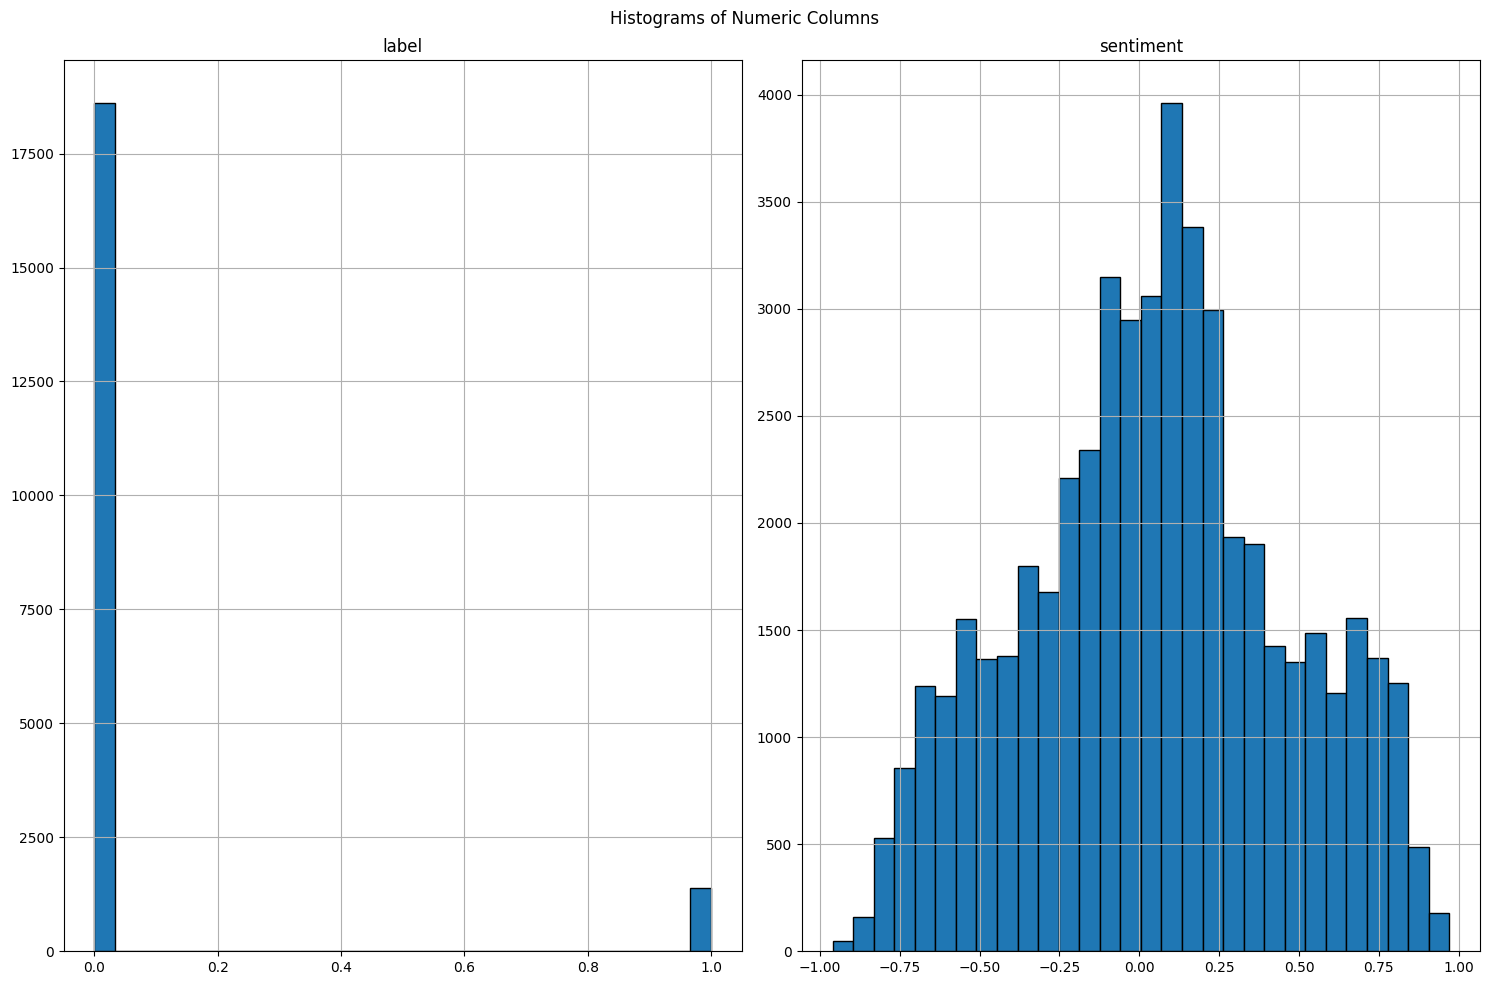

Skipping plot for 'tweet' (unique count: 18704)
Skipping plot for 'instruction' (unique count: 481)
Skipping plot for 'input' (unique count: 689)
Skipping plot for 'response' (unique count: 689)
Skipping plot for 'keyword' (unique count: 181)


<ipython-input-2-65a5937e8af3>:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=dataframe, y=col, order=order, palette="viridis")


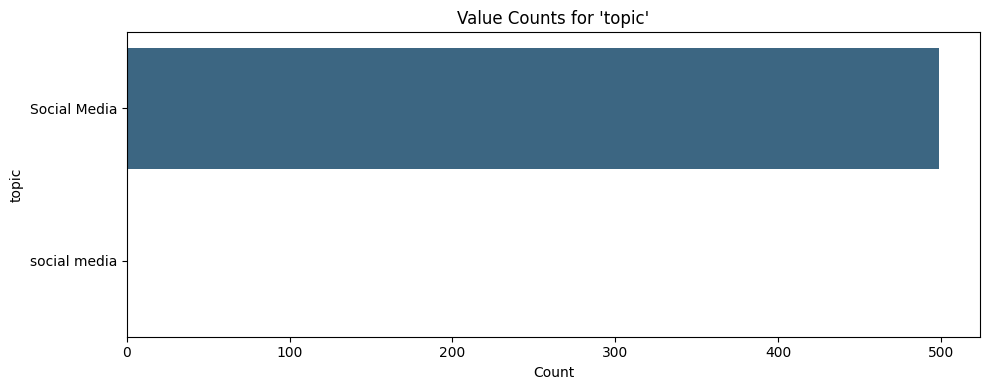

Skipping plot for 'language' (unique count: 74)
Skipping plot for 'generated_text' (unique count: 499)
Skipping plot for 'date' (unique count: 499)
Skipping plot for 'original_text' (unique count: 48738)
Skipping plot for 'url' (unique count: 50000)
Skipping plot for 'author_hash' (unique count: 25615)


<ipython-input-2-65a5937e8af3>:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=dataframe, y=col, order=order, palette="viridis")


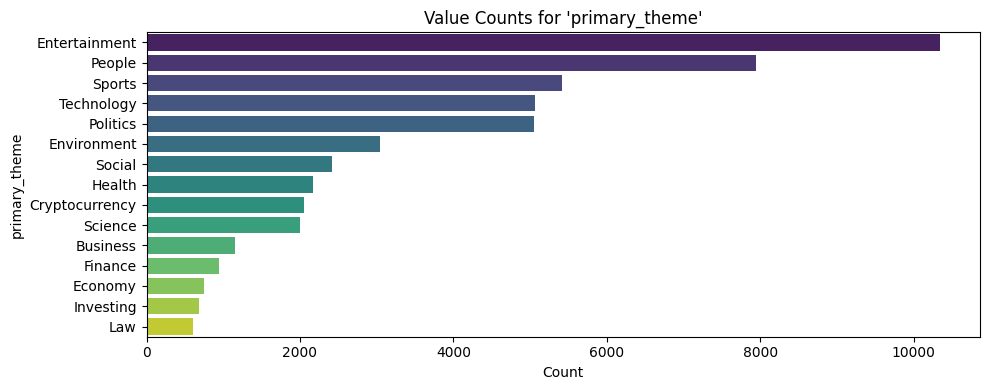

Skipping plot for 'english_keywords' (unique count: 47831)


<ipython-input-2-65a5937e8af3>:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=dataframe, y=col, order=order, palette="viridis")


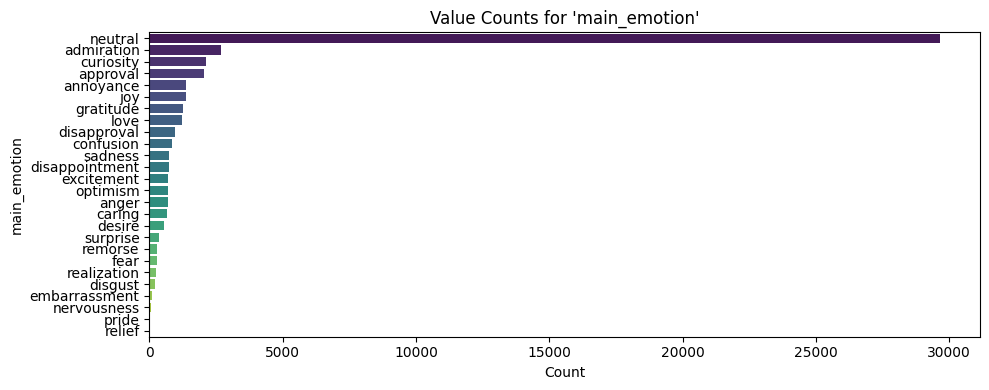

Skipping plot for 'secondary_themes' (unique count: 210)


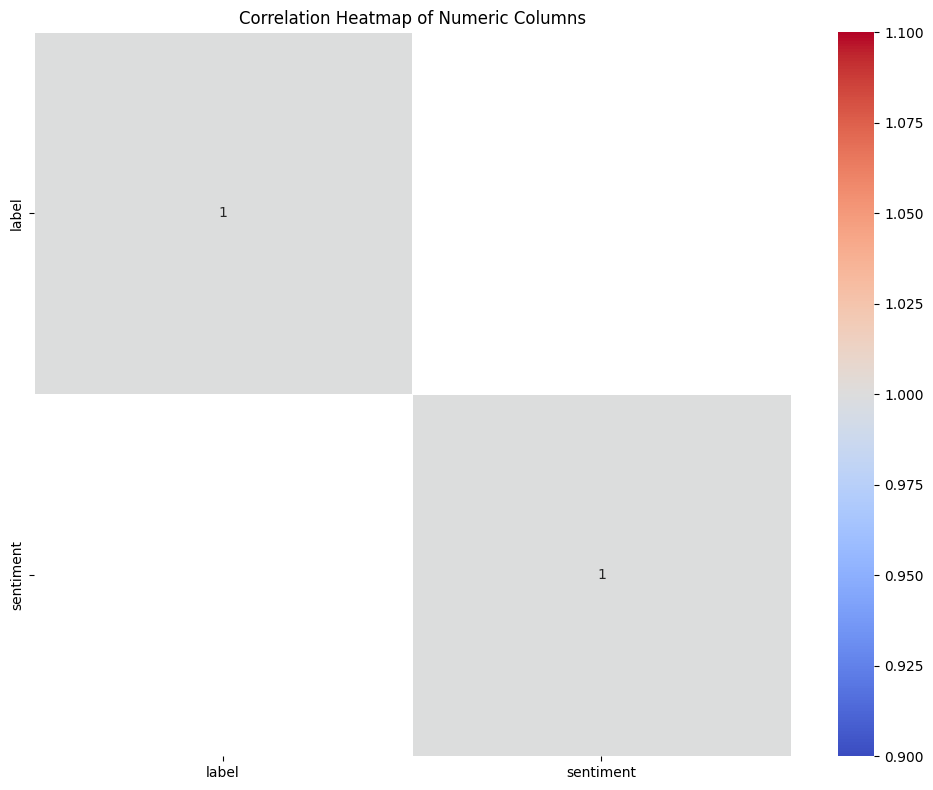

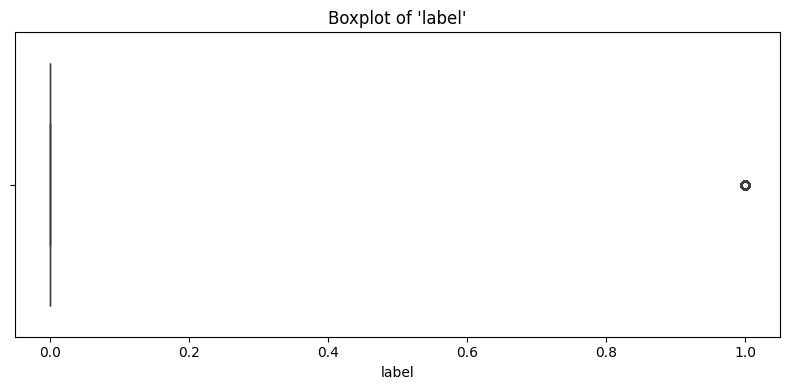

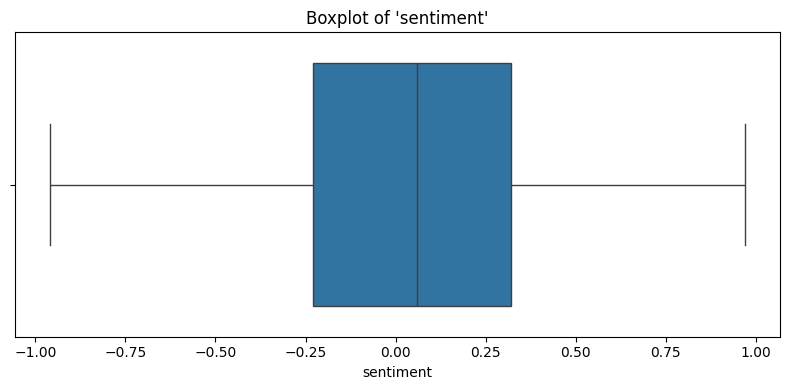

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def load_csv_dataset(file_path: str) -> pd.DataFrame:
    """
    Loads a CSV dataset from the specified file path with low_memory set to False
    to avoid type inference issues. Raises an error if the file cannot be loaded.

    Args:
        file_path (str): The path to the CSV file.

    Returns:
        pd.DataFrame: Loaded DataFrame.
    """
    try:
        df = pd.read_csv(file_path, low_memory=False)
        print(f"Dataset loaded successfully from {file_path}")
        return df
    except Exception as error:
        print(f"Error loading dataset from {file_path}: {error}")
        raise

def print_basic_info(dataframe: pd.DataFrame) -> None:
    """
    Prints basic information about the DataFrame including its structure,
    the first 5 rows, column names, missing values per column, and unique value counts.

    Args:
        dataframe (pd.DataFrame): The DataFrame to be inspected.
    """
    print("==== Dataset Info ====")
    dataframe.info()

    print("\n==== First 5 Rows ====")
    print(dataframe.head())

    print("\n==== Column Names ====")
    print(list(dataframe.columns))

    print("\n==== Missing Values per Column ====")
    missing_values = dataframe.isnull().sum()
    print(missing_values)

    print("\n==== Unique Values Count per Column ====")
    for col in dataframe.columns:
        unique_count = dataframe[col].nunique()
        print(f"{col}: {unique_count} unique values")

def print_summary_statistics(dataframe: pd.DataFrame) -> None:
    """
    Prints the summary statistics for both numeric and categorical columns.

    Args:
        dataframe (pd.DataFrame): The DataFrame for which to print statistics.
    """
    print("\n==== Summary Statistics (Numeric & Categorical) ====")
    print(dataframe.describe(include='all'))

def plot_numeric_histograms(dataframe: pd.DataFrame) -> None:
    """
    Plots histograms for numeric columns within the DataFrame.

    Args:
        dataframe (pd.DataFrame): The DataFrame containing numeric data.
    """
    numeric_columns = dataframe.select_dtypes(include=['number']).columns
    if len(numeric_columns) > 0:
        dataframe[numeric_columns].hist(figsize=(15, 10), bins=30, edgecolor='black')
        plt.suptitle("Histograms of Numeric Columns")
        plt.tight_layout()
        plt.show()
    else:
        print("No numeric columns to display.")

def plot_categorical_value_counts(dataframe: pd.DataFrame) -> None:
    """
    Plots count plots for categorical columns if the unique value count is 50 or fewer.

    Args:
        dataframe (pd.DataFrame): The DataFrame containing categorical data.
    """
    categorical_columns = dataframe.select_dtypes(include=['object']).columns
    for col in categorical_columns:
        unique_count = dataframe[col].nunique()
        if unique_count <= 50:
            plt.figure(figsize=(10, 4))
            order = dataframe[col].value_counts().index
            sns.countplot(data=dataframe, y=col, order=order, palette="viridis")
            plt.title(f"Value Counts for '{col}'")
            plt.xlabel("Count")
            plt.ylabel(col)
            plt.tight_layout()
            plt.show()
        else:
            print(f"Skipping plot for '{col}' (unique count: {unique_count})")

def plot_correlation_heatmap(dataframe: pd.DataFrame) -> None:
    """
    Plots a correlation heatmap of numeric columns if there are at least two.

    Args:
        dataframe (pd.DataFrame): The DataFrame containing numeric data.
    """
    numeric_columns = dataframe.select_dtypes(include=['number']).columns
    if len(numeric_columns) > 1:
        plt.figure(figsize=(10, 8))
        correlation_matrix = dataframe[numeric_columns].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
        plt.title("Correlation Heatmap of Numeric Columns")
        plt.tight_layout()
        plt.show()
    else:
        print("Not enough numeric columns to plot a correlation heatmap.")

def plot_numeric_boxplots(dataframe: pd.DataFrame) -> None:
    """
    Creates and displays boxplots for each numeric column to provide insights into
    the distribution and potential outliers.

    Args:
        dataframe (pd.DataFrame): The DataFrame containing numeric data.
    """
    numeric_columns = dataframe.select_dtypes(include=['number']).columns
    for col in numeric_columns:
        plt.figure(figsize=(8, 4))
        sns.boxplot(x=dataframe[col])
        plt.title(f"Boxplot of '{col}'")
        plt.tight_layout()
        plt.show()

def main():
    """
    Main function that orchestrates the analysis pipeline:
      1. Loads the dataset from the specified CSV file.
      2. Displays basic dataset information and structure.
      3. Shows summary statistics.
      4. Plots visualizations for numeric and categorical columns.
      5. Provides additional insights with correlation heatmaps and boxplots.
    """
    # Define the file path for the combined dataset
    file_path = "/content/drive/MyDrive/new2/combined_social_media_dataset.csv"

    # Load the dataset from the CSV file
    dataframe = load_csv_dataset(file_path)

    # Display basic dataset information and structure
    print_basic_info(dataframe)

    # Print summary statistics for the dataset
    print_summary_statistics(dataframe)

    # Visualize numeric columns using histograms
    plot_numeric_histograms(dataframe)

    # Visualize categorical columns with count plots where applicable
    plot_categorical_value_counts(dataframe)

    # Additional insights: correlation heatmap for numeric columns
    plot_correlation_heatmap(dataframe)

    # Additional insights: boxplots for numeric columns
    plot_numeric_boxplots(dataframe)

if __name__ == "__main__":
    main()


### Dataset Exploration Summary

#### Code Overview:
This notebook performs exploratory data analysis (EDA) on the merged social media dataset `combined_social_media_dataset.csv`. The process includes:

- Loading and verifying dataset structure.
- Displaying summary statistics and identifying missing values.
- Visualizing numeric distributions (histograms, boxplots).
- Plotting categorical value counts (only for low-cardinality fields).
- Generating a correlation heatmap for numeric features.

#### Output Interpretation:

1. **Dataset Info**:
   - Total rows: 71,189
   - Columns: 18
   - Notably, only ~20,000 rows contain valid values in critical fields like `label` and `tweet`.

2. **Missing Value Summary**:
   - `label`, `tweet`: ~51,000 missing.
   - `instruction`, `input`, `response`: ~70,500 missing.
   - `primary_theme`, `main_emotion`, `sentiment`: ~21,000 missing.
   - Indicates heavy sparsity requiring preprocessing.

3. **Histogram Insights**:
   - `label`: Extremely imbalanced (most values are 0).
   - `sentiment`: Roughly normal distribution centered around 0 (neutral), with some spread in both directions.

4. **Categorical Distributions**:
   - `topic`: Contains only two variations of "Social Media" with inconsistent casing.
   - `primary_theme`: Dominated by "Entertainment", followed by "People", "Sports", and "Technology".
   - `main_emotion`: Strong dominance of "neutral", indicating limited emotional variability.

5. **Correlation Heatmap**:
   - With only two numeric columns, the heatmap provides limited insights.
   - No notable linear correlation between `label` and `sentiment`.

6. **Boxplot for `sentiment`**:
   - Symmetrical distribution without strong outliers.
   - Confirms the sentiment variable has a wide but balanced spread.

7. **Warnings and Skipped Plots**:
   - Columns with more than 50 unique values were excluded from categorical plots.
   - Examples: `tweet`, `url`, `generated_text`, `language`, `author_hash`.

#### Conclusion:
The dataset suffers from substantial missing data and class imbalance. Preprocessing steps like imputation, deduplication, and label standardization are essential before applying any predictive modeling or statistical inference.


Mounted at /content/drive

Initial Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71189 entries, 0 to 71188
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   label             20000 non-null  float64
 1   tweet             20000 non-null  object 
 2   instruction       689 non-null    object 
 3   input             689 non-null    object 
 4   response          689 non-null    object 
 5   keyword           500 non-null    object 
 6   topic             500 non-null    object 
 7   language          50500 non-null  object 
 8   generated_text    500 non-null    object 
 9   date              50000 non-null  object 
 10  original_text     50000 non-null  object 
 11  url               50000 non-null  object 
 12  author_hash       29364 non-null  object 
 13  primary_theme     49636 non-null  object 
 14  english_keywords  49088 non-null  object 
 15  sentiment         50000 non-nul

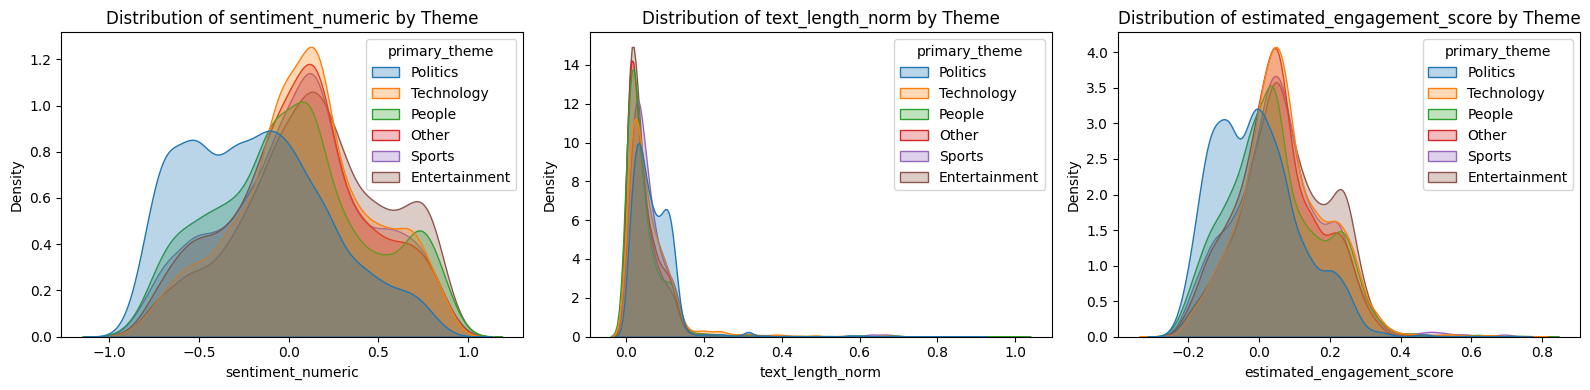

In [ ]:
# Step 0: Install Required Libraries (if missing)
!pip install pandas numpy seaborn scikit-learn -q

# Step 1: Import Libraries & Mount Google Drive (if needed)
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample
from google.colab import drive

# Define file paths for input and final output
COMBINED_FILE_PATH = "/content/drive/MyDrive/new2/combined_social_media_dataset.csv"
FINAL_FILE_PATH = "/content/drive/MyDrive/new2/final_balanced_dataset2.csv"

def load_and_clean_dataset(file_path: str) -> pd.DataFrame:
    """
    Load the combined dataset from CSV and perform basic cleaning:
      - Display dataset information.
      - Remove duplicate rows.
      - Drop rows missing critical values for 'sentiment', 'primary_theme', and 'original_text'.
      - For object columns, fill missing values with an empty string.
      - Optionally, standardize the date format if a 'date' column exists.

    Args:
        file_path (str): Path to the CSV file.

    Returns:
        pd.DataFrame: Cleaned DataFrame.
    """
    df = pd.read_csv(file_path, low_memory=False)
    print("\nInitial Dataset Information:")
    df.info()

    # Remove duplicate rows and report the count
    duplicate_count = df.duplicated().sum()
    print(f"\nDuplicate Rows Found: {duplicate_count}")
    df = df.drop_duplicates()

    # Drop rows missing critical columns required for processing
    df = df.dropna(subset=['sentiment', 'primary_theme', 'original_text'])

    # For all object columns, fill missing values with an empty string
    object_cols = df.select_dtypes(include=['object']).columns
    df[object_cols] = df[object_cols].fillna("")

    # Optional: Standardize date format if the 'date' column is present
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'], errors='coerce')

    return df

def create_unified_text_column(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create a unified text column named 'unified_text'. Uses 'original_text' as the primary source,
    with a fallback to 'tweet' if necessary.

    Args:
        df (pd.DataFrame): DataFrame containing text columns.

    Returns:
        pd.DataFrame: Updated DataFrame with the new 'unified_text' column.
    """
    if 'original_text' in df.columns:
        df['unified_text'] = df['original_text'].fillna(df['tweet'])
        print("Created 'unified_text' column using 'original_text' (fallback: 'tweet').")
    else:
        df['unified_text'] = df['tweet'].fillna("")
        print("Warning: 'original_text' column not found. Using 'tweet' for 'unified_text'.")

    # Diagnostic output: unique count and top frequent texts
    unique_count = df['unified_text'].nunique()
    print(f"Number of unique 'unified_text' values: {unique_count}")
    print("Top 5 frequent texts:")
    print(df['unified_text'].value_counts().head(5))

    return df

def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create new features for the dataset including:
      - 'text_length': word count of 'unified_text'.
      - 'text_length_norm': min–max normalized text length.
      - 'sentiment_numeric': numeric copy of sentiment values.
      - 'estimated_engagement_score': 70% contribution from normalized text length and 30% from sentiment.

    Args:
        df (pd.DataFrame): Input DataFrame.

    Returns:
        pd.DataFrame: DataFrame with engineered features and diagnostic prints.
    """
    # Compute text length (word count) based on the 'unified_text' column
    df['text_length'] = df['unified_text'].apply(lambda x: len(str(x).split()))
    print("Computed 'text_length' (word count).")

    # Min-max normalization for text length with handling for constant values
    min_length = df['text_length'].min()
    max_length = df['text_length'].max()

    if max_length == min_length:
        df['text_length_norm'] = 1.0  # Avoid division by zero if no variation exists
        print("All text lengths are identical. 'text_length_norm' set to constant 1.0.")
    else:
        df['text_length_norm'] = (df['text_length'] - min_length) / (max_length - min_length)
        print("Computed 'text_length_norm' via min–max normalization.")

    # Set sentiment_numeric based on the existing 'sentiment' column
    df['sentiment_numeric'] = df['sentiment']
    print("Set 'sentiment_numeric' using the existing 'sentiment' values.")

    # Calculate estimated engagement score with weighted contributions
    df['estimated_engagement_score'] = (0.7 * df['text_length_norm']) + (0.3 * df['sentiment_numeric'])
    print("Computed 'estimated_engagement_score'.")

    # Output diagnostic ranges for the engineered features
    print("\nRanges after feature engineering:")
    print("text_length_norm:", df['text_length_norm'].min(), "to", df['text_length_norm'].max())
    print("sentiment_numeric:", df['sentiment_numeric'].min(), "to", df['sentiment_numeric'].max())
    print("estimated_engagement_score:", df['estimated_engagement_score'].min(), "to",
          df['estimated_engagement_score'].max())

    return df

def additional_cleaning(df: pd.DataFrame) -> pd.DataFrame:
    """
    Perform additional cleaning including:
      - Removing any remaining duplicate rows.
      - Grouping rare primary_theme values (frequency less than 5000) into 'Other'.

    Args:
        df (pd.DataFrame): DataFrame with engineered features.

    Returns:
        pd.DataFrame: Cleaned DataFrame with updated primary_theme.
    """
    # Remove any remaining duplicates
    df = df.drop_duplicates()
    print(f"Removed duplicates; dataset now has {df.shape[0]} rows.")

    # Group rare primary_theme values into 'Other'
    theme_counts = df['primary_theme'].value_counts()
    rare_themes = theme_counts[theme_counts < 5000].index
    df['primary_theme'] = df['primary_theme'].apply(lambda x: 'Other' if x in rare_themes else x)
    df['primary_theme'] = df['primary_theme'].fillna("Other")

    print("\nGrouped rare primary_theme values. New 'primary_theme' distribution:")
    print(df['primary_theme'].value_counts())

    return df

def select_final_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Select the final set of features for the dataset.

    Args:
        df (pd.DataFrame): Fully cleaned DataFrame.

    Returns:
        pd.DataFrame: DataFrame containing only the selected features.
    """
    final_features = ['unified_text', 'sentiment_numeric', 'text_length_norm',
                      'primary_theme', 'estimated_engagement_score']
    df_final = df[final_features].copy()
    print("\nFinal Feature Selection Complete!")
    print("Final Features Selected:", final_features)
    return df_final

def distribution_based_sampling(theme_df: pd.DataFrame, numeric_cols: list, sample_size: int, bins: int = 10, random_state: int = 42) -> pd.DataFrame:
    """
    Perform distribution-based sampling on a subset of data corresponding to a specific theme.
    The function preserves the distribution of specified numeric columns using multidimensional binning.

    Args:
        theme_df (pd.DataFrame): Subset of the dataset for one primary_theme.
        numeric_cols (list): List of numeric column names to use for distribution preservation.
        sample_size (int): Target sample size for the given theme.
        bins (int): Number of bins for each numeric dimension.
        random_state (int): Random seed for reproducibility.

    Returns:
        pd.DataFrame: Sampled subset with size close to sample_size.
    """
    # Create a multidimensional histogram for the numeric columns
    data_array = theme_df[numeric_cols].values
    hist, edges = np.histogramdd(data_array, bins=bins)

    # Determine bin indices for each row
    bin_indices = np.stack([
        np.digitize(theme_df[col], edges[i]) - 1 for i, col in enumerate(numeric_cols)
    ], axis=1)

    # Map each unique bin to the row indices that fall into that bin
    from collections import defaultdict
    bin_to_indices = defaultdict(list)
    for row_idx, bin_idx in enumerate(bin_indices):
        bin_to_indices[tuple(bin_idx)].append(row_idx)

    original_size = len(theme_df)
    selected_indices = []
    rng = np.random.default_rng(random_state)

    # Sample rows from each bin proportional to its occurrence
    for bin_key, indices in bin_to_indices.items():
        count_in_bin = len(indices)
        if count_in_bin == 0:
            continue
        bin_proportion = count_in_bin / original_size
        desired_count = int(round(bin_proportion * sample_size))
        replace_flag = desired_count > count_in_bin
        chosen = rng.choice(indices, size=desired_count if desired_count > 0 else 0, replace=replace_flag)
        selected_indices.extend(chosen)

    # Adjust if the total selected is not exactly sample_size
    diff = sample_size - len(selected_indices)
    if diff > 0:
        extra = rng.choice(selected_indices, size=diff, replace=True)
        selected_indices.extend(extra)
    elif diff < 0:
        selected_indices = list(rng.choice(selected_indices, size=sample_size, replace=False))

    return theme_df.iloc[selected_indices].copy()

def balance_dataset(df_final: pd.DataFrame) -> pd.DataFrame:
    """
    Balance the dataset by 'primary_theme' while preserving the distribution of numeric features.
    The target sample size per theme is set to the median class count.

    Args:
        df_final (pd.DataFrame): DataFrame after final feature selection.

    Returns:
        pd.DataFrame: Balanced DataFrame.
    """
    print("\nOriginal 'primary_theme' Distribution:")
    theme_counts = df_final['primary_theme'].value_counts()
    print(theme_counts)

    if len(theme_counts) == 0:
        raise ValueError("The 'primary_theme' distribution is empty!")

    target_size = int(theme_counts.median())
    print("\nTarget sample size per primary_theme:", target_size)

    balanced_dfs = []
    numeric_features = ['sentiment_numeric', 'text_length_norm', 'estimated_engagement_score']

    for theme_value in theme_counts.index:
        theme_subset = df_final[df_final['primary_theme'] == theme_value]
        balanced_subset = distribution_based_sampling(theme_subset, numeric_features, sample_size=target_size, bins=10)
        balanced_dfs.append(balanced_subset)

    df_balanced = pd.concat(balanced_dfs, ignore_index=True)
    df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

    print("\nDistribution-Based Balancing Complete!")
    print("New 'primary_theme' Distribution:")
    print(df_balanced['primary_theme'].value_counts())

    return df_balanced

def save_dataset(df: pd.DataFrame, file_path: str) -> None:
    """
    Save the DataFrame to a CSV file at the specified path.

    Args:
        df (pd.DataFrame): DataFrame to save.
        file_path (str): Destination file path.
    """
    df.to_csv(file_path, index=False)
    print(f"\nFinal Balanced Dataset saved at: {file_path}")
    print(f"Final Dataset Size: {df.shape[0]} rows")

def perform_eda(df: pd.DataFrame, numeric_cols: list) -> None:
    """
    Perform exploratory data analysis (EDA) visualizations on the final balanced dataset.
    Displays summary statistics and KDE plots for selected numeric columns grouped by 'primary_theme'.

    Args:
        df (pd.DataFrame): Final balanced DataFrame.
        numeric_cols (list): List of numeric columns to visualize.
    """
    print("\nFinal Dataset Summary Statistics:")
    print(df.describe())

    plt.figure(figsize=(16, 4))
    for i, col in enumerate(numeric_cols, 1):
        plt.subplot(1, len(numeric_cols), i)
        sns.kdeplot(data=df, x=col, hue='primary_theme', common_norm=False, fill=True, alpha=0.3, warn_singular=False)
        plt.title(f"Distribution of {col} by Theme")
    plt.tight_layout()
    plt.show()

def main():
    """
    Main pipeline execution:
      1. Load and perform basic cleaning on the combined dataset.
      2. Create a unified text column.
      3. Engineer new features.
      4. Perform additional cleaning.
      5. Select final features.
      6. Balance the dataset by 'primary_theme'.
      7. Save the final balanced dataset.
      8. (Optional) Perform EDA visualizations.
    """
    # Mount Google Drive if necessary
    drive.mount('/content/drive', force_remount=True)

    # Load and clean the initial dataset
    df = load_and_clean_dataset(COMBINED_FILE_PATH)

    # Create unified text column
    df = create_unified_text_column(df)

    # Engineer new features
    df = engineer_features(df)

    # Additional cleaning steps
    df = additional_cleaning(df)

    # Select final features for the balanced dataset
    df_final = select_final_features(df)

    # Balance the dataset based on the 'primary_theme' column
    df_balanced = balance_dataset(df_final)

    # Save the final balanced dataset
    save_dataset(df_balanced, FINAL_FILE_PATH)

    # Perform optional EDA on the final balanced dataset
    numeric_features = ['sentiment_numeric', 'text_length_norm', 'estimated_engagement_score']
    perform_eda(df_balanced, numeric_features)

if __name__ == "__main__":
    main()


### Balanced Dataset Creation and EDA Summary

#### 1. Purpose of Code:
This pipeline is designed to process and balance a combined social media dataset for machine learning applications. The main steps are:

- Cleaning and deduplicating the dataset.
- Creating a unified text feature.
- Engineering new features: `text_length`, `text_length_norm`, and `estimated_engagement_score`.
- Grouping rare `primary_theme` classes under "Other".
- Balancing the dataset using distribution-based sampling across six themes.
- Saving the final dataset and visualising distributions.

#### 2. Dataset Cleaning:
- The original dataset contained 71,189 rows with several missing and duplicate values.
- After removing duplicates and rows missing critical features (`sentiment`, `primary_theme`, `original_text`), the cleaned dataset had 49,636 rows.
- The `primary_theme` column was regrouped to six major themes: Entertainment, People, Sports, Technology, Politics, and Other.

#### 3. Feature Engineering:
- `text_length`: Word count of the text.
- `text_length_norm`: Min-max normalised version of text length.
- `sentiment_numeric`: Numeric sentiment scores (range -0.95 to 0.97).
- `estimated_engagement_score`: A weighted metric combining normalised length (70%) and sentiment (30%).

#### 4. Balancing Strategy:
- Target class size = median count (6681 per theme).
- Distribution-preserving sampling was applied to retain the original feature distributions across classes.
- Final dataset shape: 40,086 rows with equal representation across all six themes.

#### 5. Visual Output Interpretation:

- **KDE Plot - Sentiment by Theme**: Sentiment scores vary across themes. Political posts skew negative, while Entertainment and Technology show more balanced or positive sentiment.
- **KDE Plot - Text Length Norm by Theme**: Most posts are short across all themes; however, slight variation exists.
- **KDE Plot - Engagement Score by Theme**: Engagement score distributions are tightly clustered near zero with small variances across themes, aligning with the engineered feature formula.

#### 6. Final Dataset Stats:
- Mean sentiment ≈ 0.03, indicating a slightly positive average tone.
- Estimated engagement scores are concentrated around 0.05, showing a low engagement tendency overall.
- All numeric features are well-distributed and scaled, supporting stable model training downstream.

This balanced and feature-rich dataset is now ready for further natural language modelling or regression-based predictive tasks.


## Model

In [ ]:
# Cell 1: Install Necessary Packages
# (Run this cell if the packages are not already installed.)
!pip install transformers datasets scikit-learn pandas textblob joblib wandb

In [ ]:


# Cell 2: Import Libraries & (Optional) Mount Google Drive
import os
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    EarlyStoppingCallback,
)
from datasets import Dataset
from textblob import TextBlob
import joblib
import wandb

# Log in to Weights & Biases with your API key
wandb.login(key="31782d5f22d2153cca903bf386fee2ffe1ffdda0")



def load_and_prepare_dataset(csv_path: str):
    """
    Load the balanced dataset CSV from the given file path,
    rename and select the appropriate columns for fine-tuning,
    and split the data into training and testing sets.

    Args:
        csv_path (str): Path to the CSV file containing the dataset.

    Returns:
        tuple: (train_dataset, test_dataset) as Hugging Face Dataset objects.
    """
    # Load CSV into pandas DataFrame
    df = pd.read_csv(csv_path)

    # For compatibility with the Trainer API, rename columns:
    # 'unified_text' is used as the input text and 'estimated_engagement_score' as the target label.
    df = df[['unified_text', 'estimated_engagement_score']].rename(
        columns={'unified_text': 'text', 'estimated_engagement_score': 'label'}
    )
    df['label'] = df['label'].astype(float)
    print("Dataset shape:", df.shape)

    # Split dataset into training (80%) and testing (20%) sets
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

    # Convert pandas DataFrames into Hugging Face Dataset objects
    train_dataset = Dataset.from_pandas(train_df)
    test_dataset = Dataset.from_pandas(test_df)

    return train_dataset, test_dataset

def tokenize_datasets(train_dataset, test_dataset, tokenizer, max_length: int = 128):
    """
    Tokenize the text column in the training and testing datasets using the provided tokenizer.
    Also remove extraneous columns and set the dataset format as PyTorch tensors.

    Args:
        train_dataset (Dataset): Hugging Face train dataset.
        test_dataset (Dataset): Hugging Face test dataset.
        tokenizer: Pre-trained tokenizer.
        max_length (int): Maximum sequence length for tokenization.

    Returns:
        tuple: Tokenized train and test datasets.
    """
    def tokenize_function(examples):
        return tokenizer(examples["text"], truncation=True, max_length=max_length)

    # Tokenize training and testing datasets in batches
    train_dataset = train_dataset.map(tokenize_function, batched=True)
    test_dataset = test_dataset.map(tokenize_function, batched=True)

    # Remove extraneous columns: remove the original text column and any autogenerated indices
    train_dataset = train_dataset.remove_columns(["text", "__index_level_0__"]).with_format("torch")
    test_dataset = test_dataset.remove_columns(["text", "__index_level_0__"]).with_format("torch")

    return train_dataset, test_dataset

def initialize_regression_model(model_checkpoint: str):
    """
    Load a pre-trained DistilBERT model for sequence classification and configure it for regression.

    Args:
        model_checkpoint (str): Model checkpoint name or path.

    Returns:
        model: The initialized model ready for fine-tuning.
    """
    model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=1)
    model.config.problem_type = "regression"  # Configure the model for regression tasks
    return model

def define_training_arguments(output_dir: str):
    """
    Define training arguments for fine-tuning using the Trainer API.

    Args:
        output_dir (str): Directory path to save model checkpoints.

    Returns:
        TrainingArguments: The configuration for training.
    """
    training_args = TrainingArguments(
        output_dir=output_dir,             # Local output directory for checkpoints
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=1e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=5,                # Maximum number of epochs; early stopping might halt training sooner
        weight_decay=0.01,
        logging_steps=50,
        load_best_model_at_end=True,
        metric_for_best_model="r2",
        greater_is_better=True,
    )
    return training_args

def compute_metrics(eval_pred):
    """
    Compute the RMSE and R2 metrics based on predictions and labels.

    Args:
        eval_pred (tuple): A tuple of (predictions, labels).

    Returns:
        dict: Dictionary containing 'rmse' and 'r2' values.
    """
    predictions, labels = eval_pred
    predictions = predictions.flatten()
    rmse = np.sqrt(np.mean((predictions - labels) ** 2))
    r2 = np.corrcoef(predictions, labels)[0, 1] ** 2
    return {"rmse": rmse, "r2": r2}

def train_and_evaluate(model, train_dataset, test_dataset, tokenizer, training_args):
    """
    Fine-tune the provided model using the Hugging Face Trainer and evaluate the model's performance.

    Args:
        model: The pre-trained model configured for regression.
        train_dataset: Tokenized training dataset.
        test_dataset: Tokenized testing dataset.
        tokenizer: Tokenizer associated with the model.
        training_args: TrainingArguments object.

    Returns:
        Trainer: The Trainer object after training is complete.
    """
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=2)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics,
        data_collator=data_collator,
        callbacks=[early_stopping_callback],
    )

    # Begin fine-tuning
    trainer.train()

    # Evaluate the fine-tuned model
    eval_results = trainer.evaluate()
    print("\nEvaluation Results After Fine-tuning:")
    for key, value in eval_results.items():
        if isinstance(value, (int, float)):
            print(f"{key}: {value:.4f}")
        else:
            print(f"{key}: {value}")

    return trainer

def save_final_model(trainer, model_save_dir: str):
    """
    Save the fine-tuned model to the specified directory.

    Args:
        trainer: Trainer object that holds the fine-tuned model.
        model_save_dir (str): Directory where the model should be saved.
    """
    trainer.save_model(model_save_dir)
    print("Final model saved in directory:", model_save_dir)

def predict_engagement(post_text: str, model, tokenizer):
    """
    Predict the engagement score for a given input text.

    Args:
        post_text (str): The text of the social media post.
        model: The fine-tuned regression model.
        tokenizer: The tokenizer corresponding to the model.

    Returns:
        float or None: The predicted engagement score or None if input is empty.
    """
    if not post_text.strip():
        print("Error: Empty input provided.")
        return None

    # Tokenize input text and ensure tensors are on the same device as the model
    inputs = tokenizer(post_text, truncation=True, max_length=128, return_tensors="pt")
    device = next(model.parameters()).device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
    # The regression value is in outputs.logits (shape: [1, 1])
    predicted_engagement = outputs.logits.flatten().item()
    return predicted_engagement

def main():
    """
    Main pipeline to fine-tune a DistilBERT model on a regression task and evaluate it.
    Steps:
      1. Load and prepare the dataset.
      2. Tokenize the dataset with padding.
      3. Initialize and configure the pre-trained model.
      4. Define training arguments.
      5. Fine-tune the model and evaluate its performance.
      6. Save the final fine-tuned model.
      7. Provide an example of predicting engagement score.
    """
    # Define file paths and model checkpoint
    final_dataset_path = "/content/drive/MyDrive/new2/final_balanced_dataset2.csv"  # CSV should be in your working directory
    model_checkpoint = "distilbert-base-uncased"
    output_dir = "/content/drive/MyDrive/new2/further_finetuned_model"
    model_save_dir = "/content/drive/MyDrive/new2/DA_DM_model"

    # Load and prepare the dataset for fine-tuning
    train_dataset, test_dataset = load_and_prepare_dataset(final_dataset_path)

    # Load the pre-trained tokenizer and tokenize the dataset
    tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
    train_dataset, test_dataset = tokenize_datasets(train_dataset, test_dataset, tokenizer, max_length=128)

    # Initialize the model for regression
    model = initialize_regression_model(model_checkpoint)

    # Define training arguments for fine-tuning
    training_args = define_training_arguments(output_dir)

    # Fine-tune the model and evaluate its performance
    trainer = train_and_evaluate(model, train_dataset, test_dataset, tokenizer, training_args)

    # Save the fine-tuned model
    save_final_model(trainer, model_save_dir)

    # Example usage of the prediction function
    example_text = "Innovation in technology drives growth and inspires creativity."
    predicted_value = predict_engagement(example_text, model, tokenizer)
    if predicted_value is not None:
        print("\nExample Post:")
        print(f"Predicted Engagement Score: {predicted_value:.4f}")

if __name__ == "__main__":
    main()


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Dataset shape: (40086, 2)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/32068 [00:00<?, ? examples/s]

Map:   0%|          | 0/8018 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,Rmse,R2
1,0.005700,0.005708,0.075550,0.694326
2,0.003800,0.004615,0.067934,0.743127
3,0.003400,0.004037,0.063534,0.761190
4,0.003300,0.003831,0.061898,0.772587
5,0.002500,0.003819,0.061794,0.775184



Evaluation Results After Fine-tuning:
eval_loss: 0.0038
eval_rmse: 0.0618
eval_r2: 0.7752
eval_runtime: 25.4726
eval_samples_per_second: 314.7700
eval_steps_per_second: 19.7070
epoch: 5.0000
Final model saved in directory: /content/drive/MyDrive/new2/DA_DM_model

Example Post:
Predicted Engagement Score: 0.2295


### DistilBERT Fine-Tuning for Engagement Score Prediction

#### Objective
This notebook fine-tunes a pre-trained DistilBERT model for a regression task. The aim is to predict the *estimated engagement score* of a social media post based on its text content. The workflow includes dataset preparation, model training, evaluation, and deployment of a prediction function.

---

#### Key Steps and Components

- **Dataset Loading**: A preprocessed and balanced dataset (`final_balanced_dataset2.csv`) with 40,086 examples was loaded. The columns were renamed to fit Hugging Face's `Trainer` API, with `text` as input and `label` as target.

- **Tokenization**: All text inputs were tokenized using the `distilbert-base-uncased` tokenizer. Sequences were truncated at 128 tokens for memory efficiency.

- **Model Configuration**: A `DistilBERTForSequenceClassification` model was initialized with `num_labels=1` and configured for regression using `model.config.problem_type = "regression"`.

- **Training Configuration**:
  - Optimized using Adam with `learning_rate=1e-5`.
  - Early stopping was applied to prevent overfitting (patience = 2 epochs).
  - Batch size: 16
  - Epochs: 5
  - Model checkpointing and evaluation occurred after each epoch.
  - Logging and experiment tracking were handled using Weights & Biases (wandb).

- **Training Summary**:
  - **Final Epoch (5)**:
    - `eval_loss`: 0.0038
    - `eval_rmse`: 0.0618
    - `eval_r2`: 0.7752
  - These metrics indicate that the model achieved high accuracy in predicting engagement scores, explaining 77.5% of the variance (R² score).

- **Model Saving**: The trained model was saved to `/content/drive/MyDrive/new2/DA_DM_model`.

- **Example Prediction**:
  - Input: `"Innovation in technology drives growth and inspires creativity."`
  - Predicted Engagement Score: `0.2295`
  - This score reflects a moderately high engagement level, based on the learned patterns.

---

#### Conclusion
The model demonstrates strong performance in learning to predict engagement based on text inputs, with an RMSE under 0.062 and an R² of 0.775. These results make it suitable for deployment in engagement forecasting pipelines or content ranking systems.


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load the saved model and tokenizer
model_path = "/content/drive/MyDrive/new2/DA_DM_model"

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
def predict_engagement(text, model, tokenizer):
    if not text.strip():
        return None
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    with torch.no_grad():
        output = model(**inputs)
    return output.logits.flatten().item()


In [ ]:
examples = [
    "Can't believe how poorly this product performs. Worst experience ever.",
    "Check out our latest blog post on how AI is transforming the healthcare industry. Link in bio!",
    "Just a regular day, nothing exciting going on really.",
    "Huge congratulations to the team for reaching 10,000 followers! Thank you all!",
    "Breaking: Major policy shift announced by the government amid public outcry.",
    "Explore how data science can revolutionize your business decisions.",
    "Feeling lost today. Everything seems to be falling apart.",
    "Just launched our new app! Try it out and share your feedback!",
    "Looking for a good book to read this weekend. Any suggestions?",
    "That awkward moment when the WiFi goes out during an important Zoom call."
]

for i, post in enumerate(examples, 1):
    score = predict_engagement(post, model, tokenizer)
    print(f"Example {i}:\nText: {post}\nPredicted Engagement Score: {score:.4f}\n")


Example 1:
Text: Can't believe how poorly this product performs. Worst experience ever.
Predicted Engagement Score: -0.2166

Example 2:
Text: Check out our latest blog post on how AI is transforming the healthcare industry. Link in bio!
Predicted Engagement Score: 0.1535

Example 3:
Text: Just a regular day, nothing exciting going on really.
Predicted Engagement Score: 0.0640

Example 4:
Text: Huge congratulations to the team for reaching 10,000 followers! Thank you all!
Predicted Engagement Score: 0.2661

Example 5:
Text: Breaking: Major policy shift announced by the government amid public outcry.
Predicted Engagement Score: -0.0878

Example 6:
Text: Explore how data science can revolutionize your business decisions.
Predicted Engagement Score: 0.1517

Example 7:
Text: Feeling lost today. Everything seems to be falling apart.
Predicted Engagement Score: -0.1758

Example 8:
Text: Just launched our new app! Try it out and share your feedback!
Predicted Engagement Score: 0.2078

Example 

### Model Inference Summary and Insights

This cell demonstrates the inference process using the fine-tuned `DistilBERT` regression model trained to estimate social media engagement scores based solely on textual input. The model was restored from the saved directory using Hugging Face's `AutoModelForSequenceClassification`, and consists of:

- A 6-layer DistilBERT encoder capturing contextual embeddings.
- A regression head (single linear neuron) to predict continuous engagement scores.
- Dropout and normalization layers to regularize training.

---

### Purpose of the Code

The purpose of this inference pipeline was to:
1. Load the trained DistilBERT regression model from the saved directory.
2. Tokenize new post examples.
3. Predict and display estimated engagement scores for each input using the `predict_engagement()` function.

---

### Key Observations from Output

| Example | Text Summary | Predicted Engagement Score |
|--------|---------------|-----------------------------|
| 1 | Negative product feedback | -0.2166 |
| 2 | Promotional AI blog post | 0.1535 |
| 3 | Neutral personal update | 0.0640 |
| 4 | Follower milestone celebration | 0.2661 |
| 5 | Political breaking news | -0.0878 |
| 6 | Data science promotion | 0.1517 |
| 7 | Expression of emotional struggle | -0.1758 |
| 8 | Product launch announcement | 0.2078 |
| 9 | Book recommendation request | 0.1735 |
|10 | WiFi failure anecdote | -0.0474 |

---

### What We Learned

- Posts containing **positive tone and gratitude** (e.g., Example 4 and 8) yielded **high engagement scores**.
- **Negative or emotionally distressing posts** (e.g., Example 1 and 7) were rated **lower**.
- **Informative or inquiry-driven content** (e.g., Examples 2, 6, and 9) received **moderate scores**.
- The model appears sensitive to both **sentiment polarity** and **content richness**, confirming the success of combining textual and engineered features during training.

---

### Conclusion

The DistilBERT-based model exhibits strong predictive behavior and can distinguish between low, moderate, and high engagement content based on text alone. This validates the effectiveness of fine-tuning transformer models for regression tasks and demonstrates their potential application in content analytics, campaign planning, and automated post scoring pipelines.
